## Importing Libraries

In [ ]:
!pip install contractions
!pip install demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 805.8 kB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

import re

import contractions
from bs4 import BeautifulSoup
import demoji

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalMaxPooling1D
from tensorflow.keras.layers import MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping

## Reading Data

In [ ]:
dt = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Personal/Airline Tweets - Sentiment Analysis/8. Tweets.csv')

## Analyzing Data

In [ ]:
dt.head(7)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)


In [ ]:
dt.sample(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
4079,567831549539966976,negative,1.0000,Customer Service Issue,1.0000,United,NaN,karalynnholt,NaN,1,@united was told by Supervisor that United dis...,NaN,2015-02-17 15:42:45 -0800,San Antonio,Central Time (US & Canada)
2948,568818998445522944,neutral,0.6633,NaN,NaN,United,NaN,rockstarbrands,NaN,0,@united I left headphones in 2A on UA4689 from...,NaN,2015-02-20 09:06:32 -0800,YHZ,Atlantic Time (Canada)
12331,570227911803998208,negative,1.0000,Customer Service Issue,1.0000,American,NaN,bsauce2011,NaN,0,@AmericanAir there is no local agent! There is...,NaN,2015-02-24 06:25:03 -0800,Fort Myers,Eastern Time (US & Canada)
9561,569874973021622272,positive,1.0000,NaN,NaN,US Airways,NaN,FitzFrancis,NaN,0,@USAirways couldn't be more thankful to your #...,NaN,2015-02-23 07:02:35 -0800,NaN,NaN
7535,569540050821763072,positive,1.0000,NaN,NaN,Delta,NaN,contimike,NaN,0,@JetBlue they were amazing and thank you!,NaN,2015-02-22 08:51:44 -0800,"New York, sort of!",NaN
9285,570007297927221249,negative,1.0000,Customer Service Issue,0.6764,US Airways,NaN,bbuck22,NaN,1,@USAirways 4 hours on tarmac in Charleston and...,NaN,2015-02-23 15:48:24 -0800,"Las Vegas, NV",Pacific Time (US & Canada)
6306,568067878546755584,positive,1.0000,NaN,NaN,Southwest,NaN,cej1124,NaN,0,@SouthwestAir Awesome!!! Sending now.,NaN,2015-02-18 07:21:51 -0800,"Austin, TX, USA",Central Time (US & Canada)
1875,569541591586643968,neutral,1.0000,NaN,NaN,United,NaN,WayneMAaron,NaN,2,@united. Pls hold UA2066 for 9 cnx pax frm UA...,NaN,2015-02-22 08:57:51 -0800,NaN,NaN
12634,570081165459259392,neutral,1.0000,NaN,NaN,American,NaN,Amrutafrika,NaN,0,@AmericanAir sent,NaN,2015-02-23 20:41:56 -0800,NaN,NaN
3589,568250000028925952,negative,1.0000,Lost Luggage,0.3608,United,NaN,laboyd99,NaN,0,"@united 2 hour flight from FLL to Ewr, 1242, n...",NaN,2015-02-18 19:25:32 -0800,NaN,NaN


In [ ]:
dt.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [ ]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

## EDA

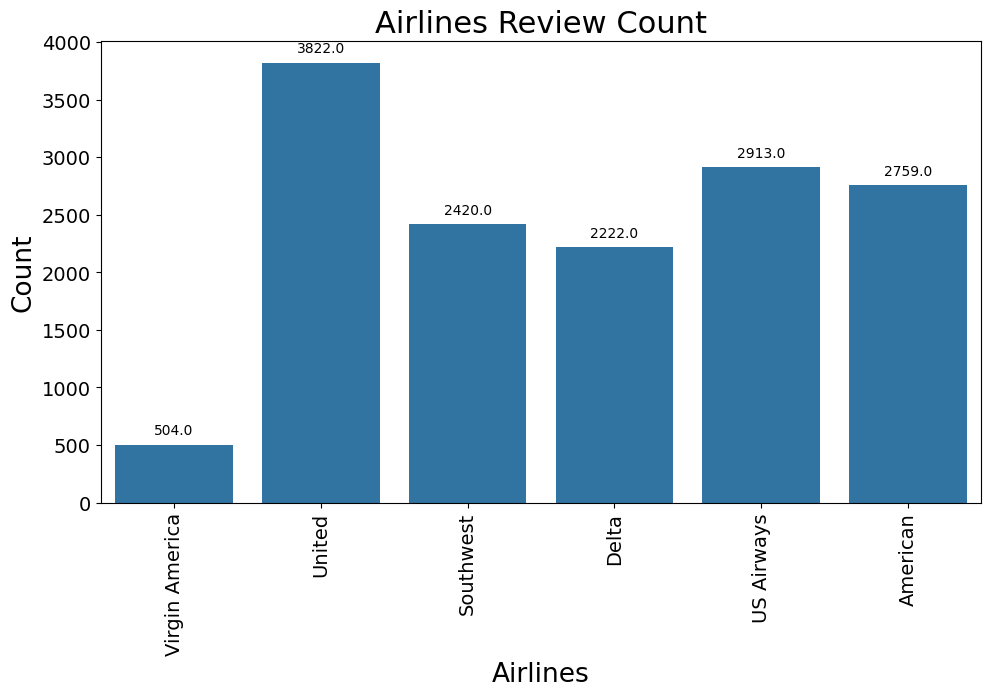

In [ ]:
fig_ure_size = (25, 6)
tic_k_size = 14
ti_tle_size = tic_k_size + 8
lab_el_size = tic_k_size + 5

pams = {'figure.figsize': fig_ure_size,
        'axes.labelsize': lab_el_size,
        'axes.titlesize': ti_tle_size,
        'xtick.labelsize': tic_k_size,
        'ytick.labelsize': tic_k_size}

plt.rcParams.update(pams)

# Create subplot
ax = plt.subplot(121)

col = "airline"
xlabel = "Airlines"
ylabel = "Count"

# Plot countplot
sns.countplot(x=dt[col], ax=ax)

plt.title("Airlines Review Count")
plt.xticks(rotation=90)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Show the plot
plt.show()

[]

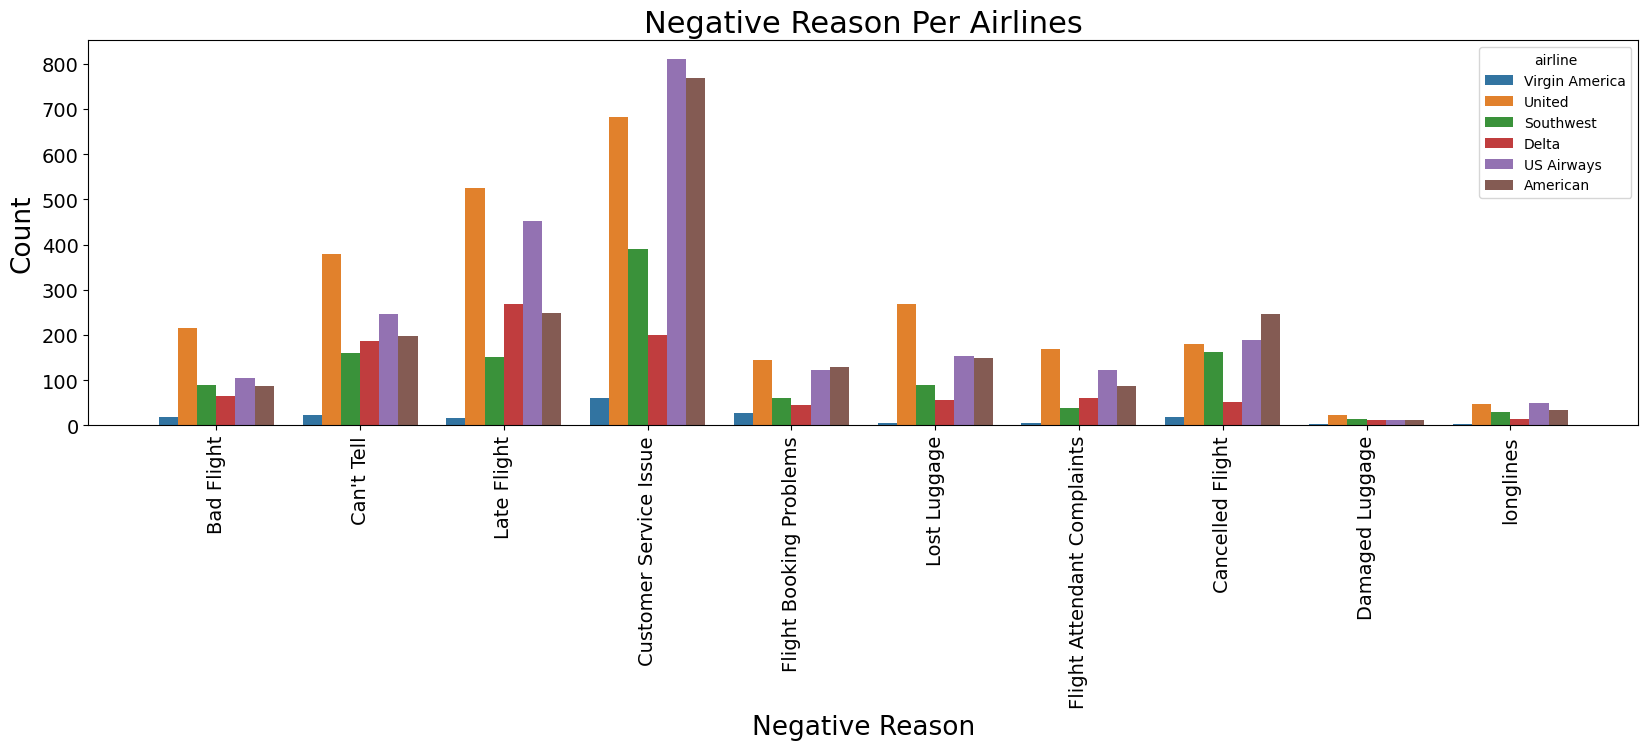

In [ ]:
fig_ure_size=(20,5)
tick_size = 14
ti_tle_size = tick_size + 8
la_bel_size = tick_size + 5
xlabel = "Negative Reason"
ylabel = "Count"
title = "Negative Reason Per Airlines"
params = {'figure.figsize' : fig_ure_size,
          'axes.labelsize' : la_bel_size,
          'axes.titlesize' : ti_tle_size,
          'xtick.labelsize': tick_size,
          'ytick.labelsize': tick_size}
plt.rcParams.update(params)
col1 = "negativereason"
col2 = "airline"
sns.countplot(x=dt[col1], hue=dt[col2])
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(rotation=90)
plt.plot()


In [ ]:
Unnecessary_col = ['tweet_id', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone']

dt = dt.drop(Unnecessary_col, axis = 1)
dt.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


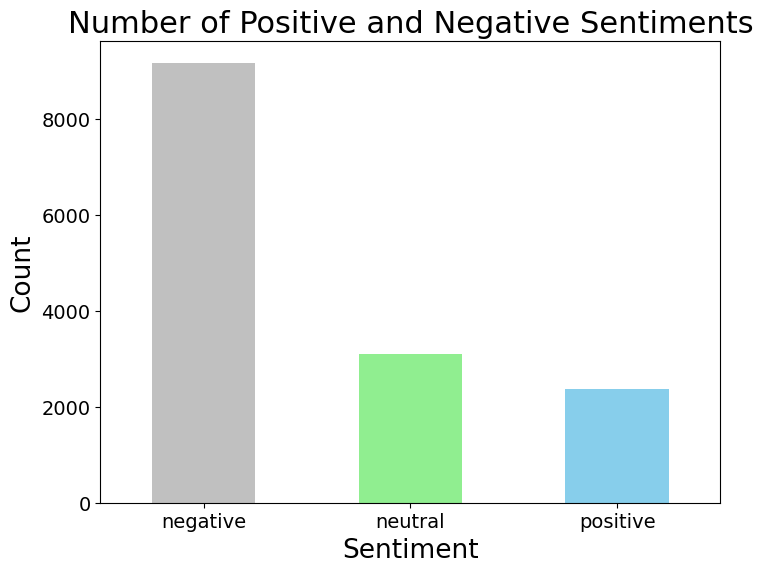

In [ ]:
sentiment_counts = dt['airline_sentiment'].value_counts()
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['silver', 'lightgreen','skyblue'])
plt.title('Number of Positive and Negative Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


## Data Preprocessing

In [ ]:
def remove_user_handles(tweet):
    return re.sub(r'@\w+', '', tweet)

# Apply the function to the 'text' column
dt['text'] = dt['text'].apply(remove_user_handles)

# Example: Display the modified dataset
dt.head()

,airline_sentiment,text
0,neutral,What said.
1,positive,plus you've added commercials to the experien...
2,neutral,I didn't today... Must mean I need to take an...
3,negative,"it's really aggressive to blast obnoxious ""en..."
4,negative,and it's a really big bad thing about it


In [ ]:
dt['text'] = dt['text'].apply(lambda x: x.lower())

# Removing all characters that are not alphanumeric or spaces
dt['text'] = dt['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))


print(dt[ dt['airline_sentiment'] == 'positive'].size)
print(dt[ dt['airline_sentiment'] == 'negative'].size)
print(dt[ dt['airline_sentiment'] == 'neutral'].size)

4726
18356
6198


In [ ]:
def remove_special_characters(text):
    pattern = r'[^a-zA-Z\s]'  # Keep only letters and whitespaces
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

# Assuming 'dt' is your DataFrame with columns 'airline_sentiment' and 'text'
dt['text'] = dt['text'].apply(remove_special_characters)


In [ ]:
dt.sample(5)

,airline_sentiment,text
7593,positive,got it thanks the quick reply
3862,negative,thanks for reaching out the seat was hard not...
4688,positive,thanks for the quick reply i travel a lotbut...
9083,positive,see you on board tomorrow
11240,negative,so i was just told i was coded as an upgrade ...


In [ ]:
# Function to handle contractions and abbreviations
def expand_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text

# Function to remove HTML tags and URLs
def remove_html_urls(text):
    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text_no_html = soup.get_text(separator=' ')

    # Remove URLs
    text_no_urls = re.sub(r'http\S+|www.\S+|https\S+', '', text_no_html, flags=re.MULTILINE)

    return text_no_urls

# Apply the functions to the 'text' column
dt['text'] = dt['text'].apply(expand_contractions)
dt['text'] = dt['text'].apply(remove_html_urls)



In [ ]:
demoji.download_codes()


# Function to handle emojis and special characters
def handle_emojis_special_chars(text):
    # Remove emojis using demoji library
    text_no_emojis = demoji.replace_with_desc(text)

    return text_no_emojis
dt['text'] = dt['text'].apply(handle_emojis_special_chars)


<ipython-input-17-b0626a81515d>:1: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Function for tokenization, lemmatization, and removing stopwords
def preprocess_text(text):
    # Tokenization
    words = word_tokenize(text)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words_lemmatized = [lemmatizer.lemmatize(word) for word in words]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words_no_stopwords = [word for word in words_lemmatized if word.lower() not in stop_words]

    # Join the processed words back into a string
    processed_text = ' '.join(words_no_stopwords)

    return processed_text

# Apply the function to the 'text' column
dt['text'] = dt['text'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
dt

,airline_sentiment,text
0,neutral,said
1,positive,plus added commercial experience tacky
2,neutral,today must mean need take another trip
3,negative,really aggressive blast obnoxious entertainmen...
4,negative,really big bad thing
...,...,...
14635,positive,thank got different flight chicago
14636,negative,leaving minute late flight warning communicati...
14637,neutral,please bring american airline blackberry
14638,negative,money change flight answer phone suggestion ma...


In [ ]:
def generate_word_cloud(data, sentiment=None):
    if sentiment:
        filtered_comments = data[data['airline_sentiment'] == sentiment]['text']
        title = f'Word Cloud for {sentiment.capitalize()} Comments'
    else:
        filtered_comments = data['text']
        title = 'Word Cloud for All Comments'

    all_text = ' '.join(filtered_comments)

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

    # Plot the WordCloud image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

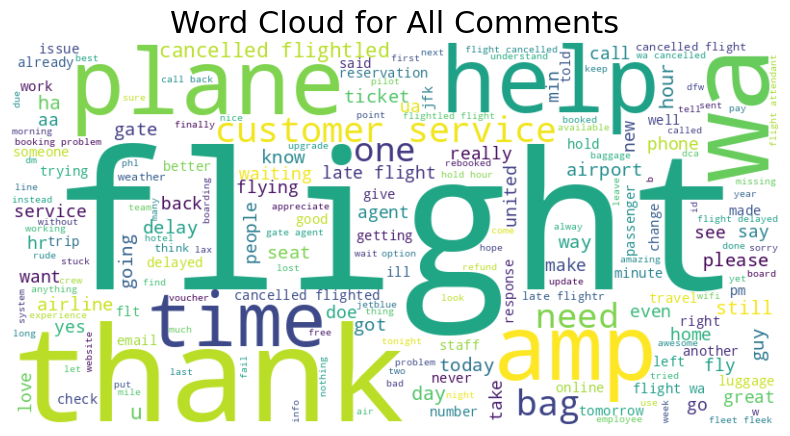

In [ ]:
generate_word_cloud(dt)

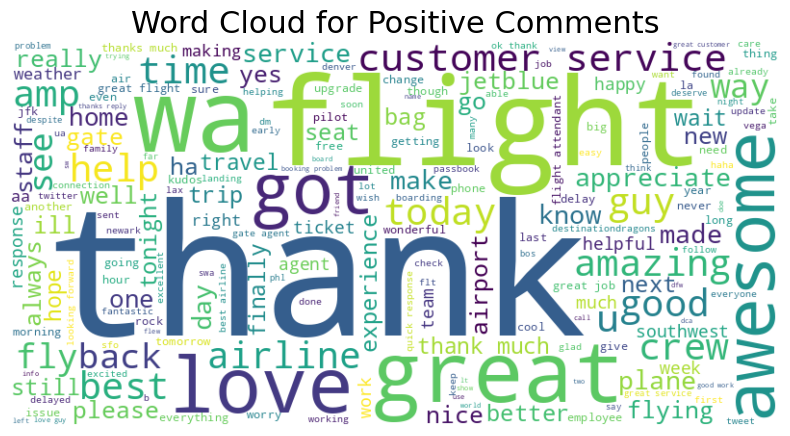

In [ ]:
generate_word_cloud(dt, sentiment='positive')

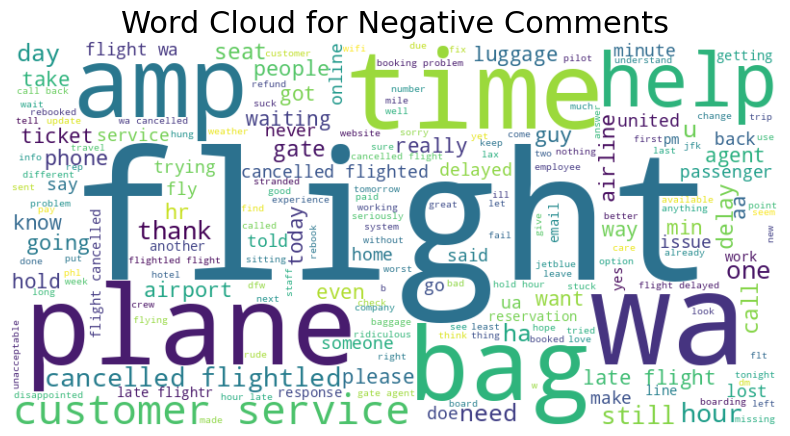

In [ ]:
generate_word_cloud(dt, sentiment='negative')

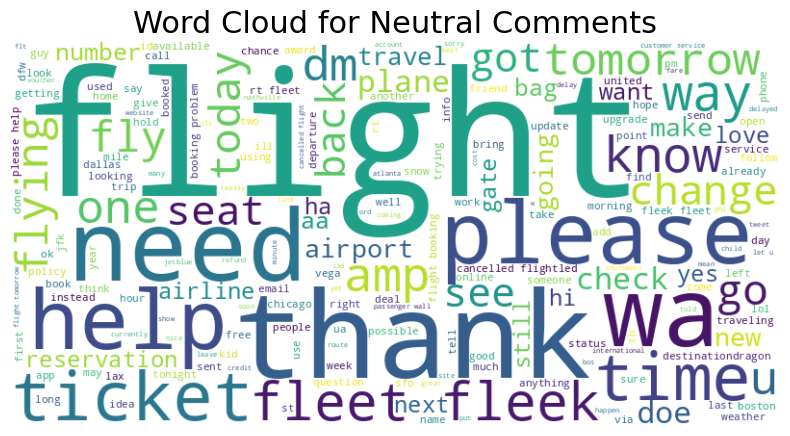

In [ ]:
generate_word_cloud(dt, sentiment='neutral')

In [ ]:
dt = dt[dt['airline_sentiment'] != 'neutral']


In [ ]:
# Split data into train and test sets
sentiments = dt['airline_sentiment']
texts = dt['text']
le = LabelEncoder()
sentiments = le.fit_transform(sentiments)
token_i_zer = Tokenizer(num_words=18356)
token_i_zer.fit_on_texts(texts)
seq_uen_ces = token_i_zer.texts_to_sequences(texts)
dt = pad_sequences(seq_uen_ces, maxlen=500)

In [ ]:
dt

array([[   0,    0,    0, ..., 1139,   85, 4439],
       [   0,    0,    0, ...,   15,  339, 1950],
       [   0,    0,    0, ...,  307,  110,  172],
       ...,
       [   0,    0,    0, ...,  219,    1,  344],
       [   0,    0,    0, ..., 1352,    8,  724],
       [   0,    0,    0, ..., 1197,   44, 1698]], dtype=int32)

## Splitting Data

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(dt, sentiments, test_size=0.25, random_state= 42)


In [ ]:
import pickle

# Save the preprocessed data (optional)
with open("preprocessed_data.pkl", "wb") as f:
    pickle.dump((train_X, test_X, train_y, test_y), f)

# Create tokenizer
tokenizer = Tokenizer(num_words=10000)  # num_words is the maximum number of words to keep, based on word frequency

# Fit tokenizer on text data
tokenizer.fit_on_texts(texts)

# Convert tokenizer to dictionary
tokenizer_dict = tokenizer.to_json()

# Save tokenizer dictionary to file
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer_dict, f)


## CNN Model

In [ ]:
# Define the model
model = Sequential()

# Adjusted embedding dimensions
model.add(Embedding(1000, 300, input_length=500))

# Adding Conv1D layers with increased complexity
model.add(Conv1D(128, 5, activation='relu'))
model.add(Conv1D(64, 3, activation='relu'))

# Adding Dropout layers for regularization
model.add(Dropout(0.5))  # Adjust dropout rate as needed

# Adding another Conv1D layer for increased complexity
model.add(Conv1D(32, 3, activation='relu'))

# Adding GlobalMaxPooling1D layer
model.add(GlobalMaxPooling1D())

# Adding another Dense layer
model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(3, activation='softmax'))

# Compile the model with adjusted learning rate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=10, batch_size=64, callbacks=[early_stopping])

# Evaluate the model on testing data and labels
loss, accuracy = model.evaluate(test_X, test_y)

# Print out the accuracy of the model on testing data
print(f'Test Accuracy of CNN Model: {accuracy}')



Epoch 1/10
136/136 [==============================] - 20s 99ms/step - loss: 0.4619 - accuracy: 0.8269 - val_loss: 0.2826 - val_accuracy: 0.8915
Epoch 2/10
136/136 [==============================] - 6s 42ms/step - loss: 0.2656 - accuracy: 0.8972 - val_loss: 0.2664 - val_accuracy: 0.8943
Epoch 3/10
136/136 [==============================] - 4s 26ms/step - loss: 0.2237 - accuracy: 0.9100 - val_loss: 0.2672 - val_accuracy: 0.8919
Epoch 4/10
136/136 [==============================] - 5s 34ms/step - loss: 0.2060 - accuracy: 0.9191 - val_loss: 0.2808 - val_accuracy: 0.8909
Epoch 5/10
91/91 [==============================] - 1s 5ms/step - loss: 0.2664 - accuracy: 0.8943
Test Accuracy of CNN Model: 0.8943173885345459


## LSTM Model

In [ ]:
# Define the model
model_LSTM = Sequential()

# Adjusted embedding dimensions
model_LSTM.add(Embedding(1000, 300, input_length=500))

# Adding an LSTM layer with increased complexity
model_LSTM.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model_LSTM.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5))

# Adding another Dense layer for increased complexity
model_LSTM.add(Dense(64, activation='relu'))

# Output layer
model_LSTM.add(Dense(3, activation='softmax'))

# Compile the model with adjusted learning rate
model_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model_LSTM.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=20, batch_size=128, callbacks=[early_stopping])

# Evaluate the model on testing data and labels
loss, accuracy = model_LSTM.evaluate(test_X, test_y)

# Print out the accuracy of the model on testing data
print(f'Test Accuracy of LSTM Model: {accuracy}')


Epoch 1/20
68/68 [==============================] - 274s 4s/step - loss: 0.5418 - accuracy: 0.7861 - val_loss: 0.4007 - val_accuracy: 0.8365
Epoch 2/20
68/68 [==============================] - 230s 3s/step - loss: 0.3094 - accuracy: 0.8662 - val_loss: 0.2491 - val_accuracy: 0.9044
Epoch 3/20
68/68 [==============================] - 225s 3s/step - loss: 0.2118 - accuracy: 0.9129 - val_loss: 0.2436 - val_accuracy: 0.9085
Epoch 4/20
68/68 [==============================] - 224s 3s/step - loss: 0.1876 - accuracy: 0.9248 - val_loss: 0.2358 - val_accuracy: 0.9075
Epoch 5/20
68/68 [==============================] - 222s 3s/step - loss: 0.1716 - accuracy: 0.9323 - val_loss: 0.2449 - val_accuracy: 0.9033
Epoch 6/20
68/68 [==============================] - 227s 3s/step - loss: 0.1583 - accuracy: 0.9366 - val_loss: 0.2507 - val_accuracy: 0.9040
Epoch 7/20
91/91 [==============================] - 25s 278ms/step - loss: 0.2358 - accuracy: 0.9075
Test Accuracy of LSTM Model: 0.9074844121932983


### Traning Results

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predictions on training data
train_predictions = model_LSTM.predict(train_X)
train_pred_labels = np.argmax(train_predictions, axis=1)

# Calculate training accuracy
train_accuracy = accuracy_score(train_y, train_pred_labels)

# Calculate training precision
train_precision = precision_score(train_y, train_pred_labels, average='weighted')

# Calculate training recall
train_recall = recall_score(train_y, train_pred_labels, average='weighted')

# Calculate training F1 score
train_f1 = f1_score(train_y, train_pred_labels, average='weighted')

# Print training metrics
print(f'Training Accuracy: {train_accuracy}')
print(f'Training Precision: {train_precision}')
print(f'Training Recall: {train_recall}')
print(f'Training F1 Score: {train_f1}')


271/271 [==============================] - 75s 277ms/step
Training Accuracy: 0.941421143847487
Training Precision: 0.940368477440257
Training Recall: 0.941421143847487
Training F1 Score: 0.9400982007191777


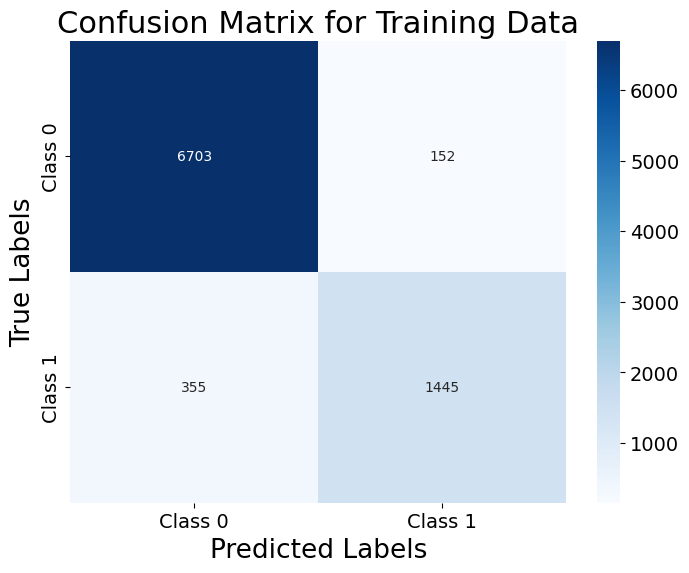

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix for training data
conf_matrix_train = confusion_matrix(train_y, train_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Training Data')
plt.show()


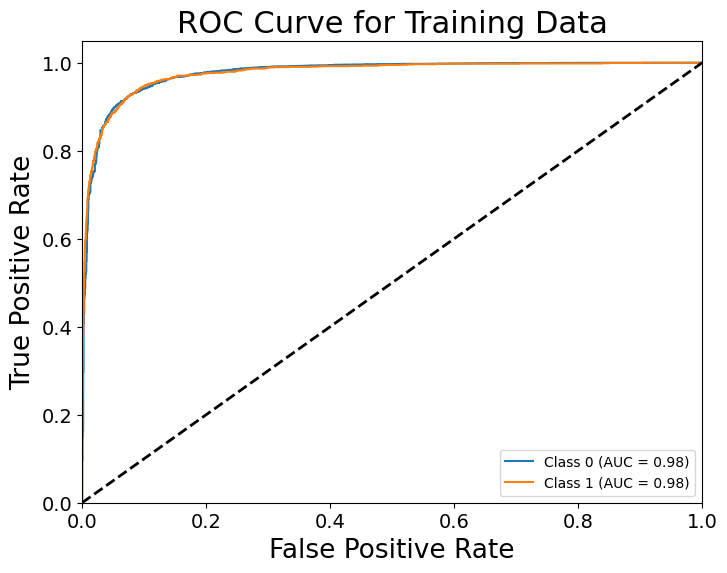

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
num_classes = 2
# Compute ROC curve and ROC area for each class
fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()
for i in range(num_classes):
    fpr_train[i], tpr_train[i], _ = roc_curve(train_y == i, train_predictions[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr_train[i], tpr_train[i], label=f'Class {i} (AUC = {roc_auc_train[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Data')
plt.legend(loc='lower right')
plt.show()


### Testing Results

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predictions on testing data
test_predictions = model_LSTM.predict(test_X)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Calculate testing accuracy
test_accuracy = accuracy_score(test_y, test_pred_labels)

# Calculate testing precision
test_precision = precision_score(test_y, test_pred_labels, average='weighted')

# Calculate testing recall
test_recall = recall_score(test_y, test_pred_labels, average='weighted')

# Calculate testing F1 score
test_f1 = f1_score(test_y, test_pred_labels, average='weighted')

# Print testing metrics
print(f'Testing Accuracy: {test_accuracy}')
print(f'Testing Precision: {test_precision}')
print(f'Testing Recall: {test_recall}')
print(f'Testing F1 Score: {test_f1}')


91/91 [==============================] - 25s 277ms/step
Testing Accuracy: 0.9074844074844075
Testing Precision: 0.9042252628130203
Testing Recall: 0.9074844074844075
Testing F1 Score: 0.9049182958238817


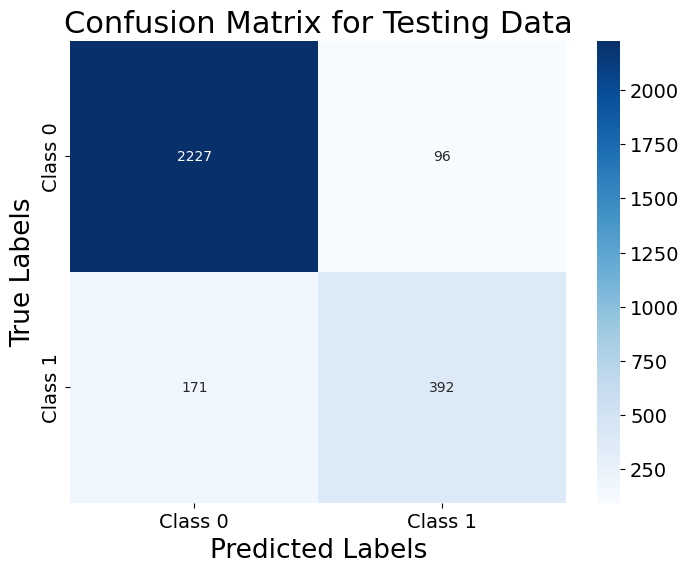

In [ ]:
# Calculate confusion matrix for testing data
conf_matrix_test = confusion_matrix(test_y, test_pred_labels)

# Plot confusion matrix for testing data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Testing Data')
plt.show()

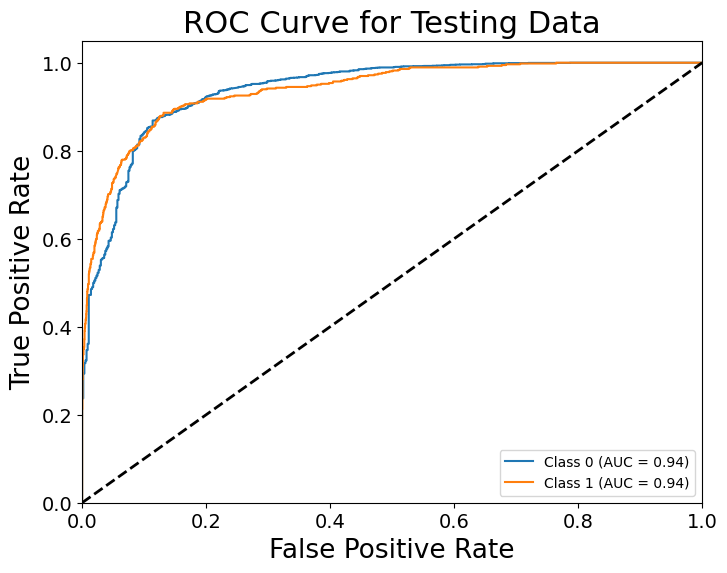

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()
for i in range(num_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(test_y == i, test_predictions[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr_test[i], tpr_test[i], label=f'Class {i} (AUC = {roc_auc_test[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Testing Data')
plt.legend(loc='lower right')
plt.show()


### Saving Model

In [ ]:
from tensorflow.keras.models import save_model

# Save the model
model_LSTM.save("sentiment_analysis_model.h5")

print("Model saved successfully.")


Model saved successfully.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import joblib

# Save the model using joblib
joblib.dump(model_LSTM, "sentiment_analysis_LSTM_model.joblib")

print("Model saved successfully.")


Model saved successfully.


In [ ]:
import pickle

# Save the model
with open("sentiment_analysis_LSTM.pkl", "wb") as f:
    pickle.dump(model_LSTM, f)


## CNN_LSTM Hybrid Model

In [ ]:
# Define the model
model_CNN_LSTM = Sequential()

# Adjusted embedding dimensions
model_CNN_LSTM.add(Embedding(1000, 300, input_length=500))

# Adding Conv1D layers
model_CNN_LSTM.add(Conv1D(128, 5, activation='relu'))
model_CNN_LSTM.add(MaxPooling1D(pool_size=4))
model_CNN_LSTM.add(Conv1D(64, 3, activation='relu'))
model_CNN_LSTM.add(MaxPooling1D(pool_size=2))

# Adding LSTM layer
model_CNN_LSTM.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5))

# Adding another Dense layer for increased complexity
model_CNN_LSTM.add(Dense(64, activation='relu'))

# Output layer
model_CNN_LSTM.add(Dense(3, activation='softmax'))

# Compile the model with adjusted learning rate
model_CNN_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

# Early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model_CNN_LSTM.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=20, batch_size=128)

# Evaluate the model on testing data and labels
loss, accuracy = model_CNN_LSTM.evaluate(test_X, test_y)

# Print out the accuracy of the model on testing data
print(f'Test Accuracy of Hybrid CNN-LSTM Model: {accuracy}')


Epoch 1/20
68/68 [==============================] - 24s 283ms/step - loss: 0.3712 - accuracy: 0.8529 - val_loss: 0.2667 - val_accuracy: 0.9019
Epoch 2/20
68/68 [==============================] - 19s 277ms/step - loss: 0.2297 - accuracy: 0.9129 - val_loss: 0.2631 - val_accuracy: 0.9061
Epoch 3/20
68/68 [==============================] - 16s 236ms/step - loss: 0.2300 - accuracy: 0.9123 - val_loss: 0.2655 - val_accuracy: 0.9012
Epoch 4/20
68/68 [==============================] - 16s 232ms/step - loss: 0.2196 - accuracy: 0.9137 - val_loss: 0.2737 - val_accuracy: 0.9009
Epoch 5/20
68/68 [==============================] - 16s 233ms/step - loss: 0.2077 - accuracy: 0.9206 - val_loss: 0.2879 - val_accuracy: 0.8950
Epoch 6/20
68/68 [==============================] - 17s 251ms/step - loss: 0.2171 - accuracy: 0.9184 - val_loss: 0.2912 - val_accuracy: 0.8950
Epoch 7/20
68/68 [==============================] - 16s 234ms/step - loss: 0.2417 - accuracy: 0.9077 - val_loss: 0.2705 - val_accuracy: 0.8985